<a href="https://colab.research.google.com/github/tjens150/ML_practice/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder
Experimenting with developing a variational autoencoder to generate synthetic spectra of stars.

In [1]:
import numpy as np
from astropy.io import fits
import pylab as plt # only needed for verification

Preparing to load stellar spectra from SDSS' Apogee telescope. Data loading is thanks to David W. Hogg at NYU

In [2]:
# construct url to the file of labels and read it
base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/"
fn = "allStarLite-dr17-synspec_rev1.fits"
allstar = fits.open(base_url + fn)
for a in allstar:
    print(a)

(5.0, 0.0)

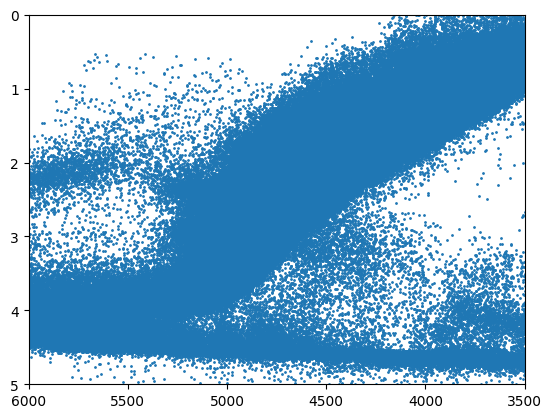

In [3]:
# the labels are in an enormous table in element [1] of this FITS file
labels = allstar[1].data
plt.scatter(labels['TEFF'], labels['LOGG'], s=1)
plt.xlim(6000, 3500)
plt.ylim(5, 0)

Pick out standard red-giant-branch stars.

In [4]:
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
print(np.sum(RGB))

145991


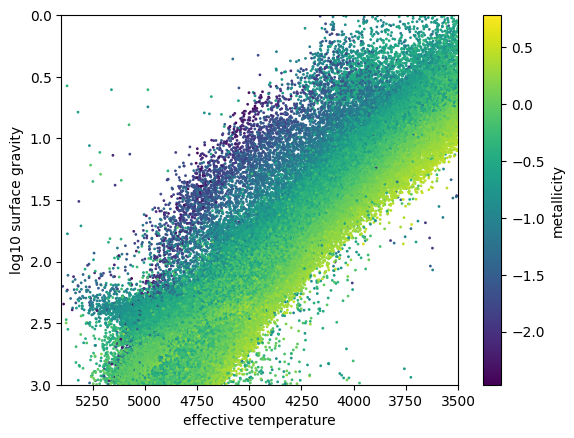

In [5]:
# make a plot that an astronomer likes to see
RGB_labels = labels[RGB]
plt.scatter(RGB_labels['TEFF'], RGB_labels['LOGG'], c=RGB_labels['FE_H'], s=1)
plt.xlim(5400, 3500)
plt.xlabel("effective temperature")
plt.ylim(3., 0.)
plt.ylabel("log10 surface gravity")
plt.colorbar(label="metallicity")

In [6]:
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]
train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

1024 256 512


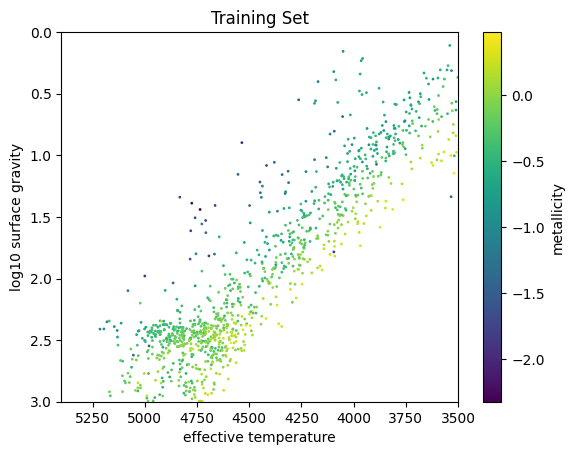

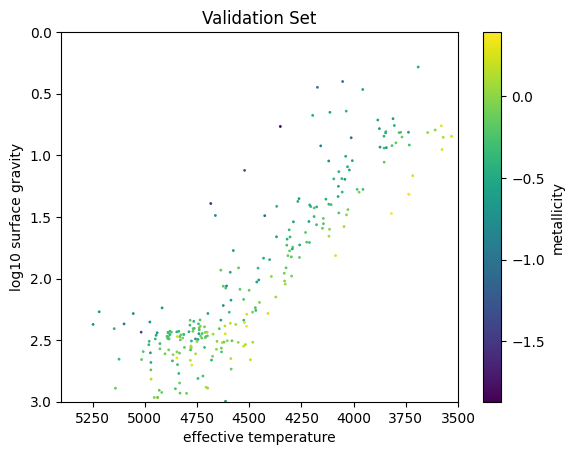

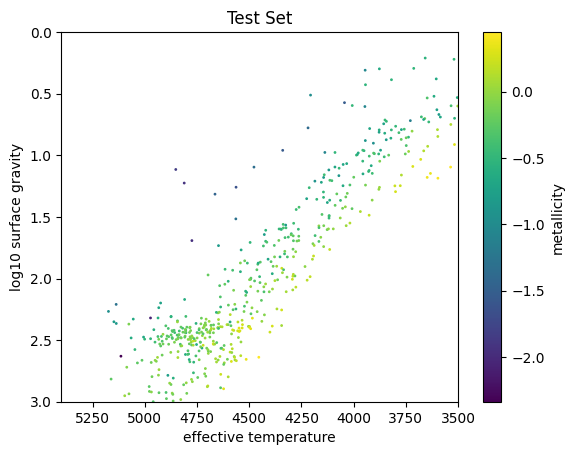

In [7]:
# Plot the labels of the three data sets
# make a plot that an astronomer likes to see
for l, t in [(train_labels, "Training Set"),
             (valid_labels, "Validation Set"),
             (test_labels, "Test Set")]:
    plt.figure()
    plt.title(t)
    plt.scatter(l['TEFF'], l['LOGG'], c=l['FE_H'], s=1)
    plt.xlim(5400, 3500)
    plt.xlabel("effective temperature")
    plt.ylim(3., 0.)
    plt.ylabel("log10 surface gravity")
    plt.colorbar(label="metallicity")

This part of the code actually loads in the spectra of each star we have selected given the criteria above (red-giant-branch).

In [8]:
# now time to read the spectral data - the features - this HURTS
def get_features(labels):
    features = None
    for l in labels:
        url = base_url + l['TELESCOPE'] + "/" + l['FIELD'] + "/aspcapStar-dr17-" + l['APOGEE_ID'] + ".fits"
        x = fits.open(url)[1].data
        if features is None:
            features = x[None, :]
        else:
            features = np.concatenate((features, x[None, :]), axis=0)
    return features

In [9]:
# This will take a while, the first time you run it. Don't be alarmed.
train_features_pre = get_features(train_labels)
valid_features_pre = get_features(valid_labels)
test_features_pre = get_features(test_labels)
print(train_features_pre.shape, valid_features_pre.shape, test_features_pre.shape)

NameError: name 'train_features' is not defined

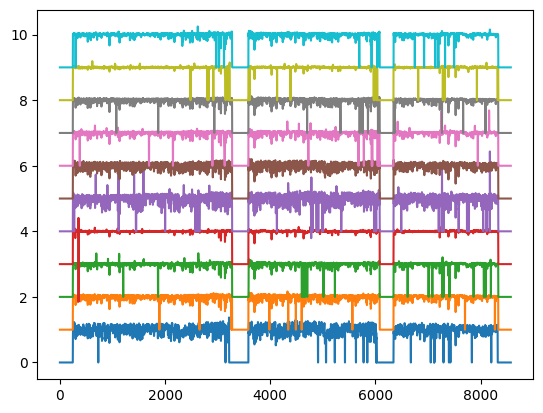

In [10]:
for i in range(10):
    plt.plot(train_features_pre[i] + i)

We can afford to clip the ends of our wavelength range because there is no information as we can tell from the above plot. Therefore we reduce the number of "features" (wavelength range) to be a power of 2.

In [11]:
mfeat=train_features_pre.shape[-1]
mfeatev=int(2**np.floor(np.log2(mfeat)))
featcut=int((mfeat-mfeatev)/2)
odd_ad=featcut % 2
train_features=train_features_pre[:,(featcut+odd_ad):-featcut]
valid_features=valid_features_pre[:,(featcut+odd_ad):-featcut]
test_features=test_features_pre[:,(featcut+odd_ad):-featcut]
mfeat=train_features.shape[-1]

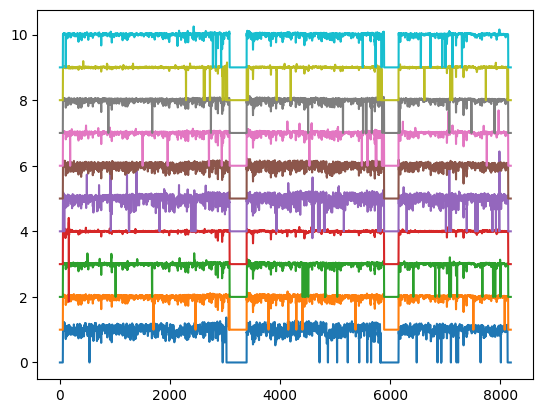

In [12]:
for i in range(10):
    plt.plot(train_features[i] + i)

In [13]:
pip install --upgrade tensorflow

In [14]:
import tensorflow as tf
import pandas as pd
#from sklearn.preprocessing import StandardScaler

#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(1)

# MLP
Start off seeing how a basic MLP fares in predicting labels (surface gravity of stars)

In [15]:
def create_dataset(feat,labels,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((feat, labels))
    return dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(1)
batch_size=32


In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels['LOGG']))
for line in train_dataset.take(5):
  print(line)


(<tf.Tensor: shape=(8192,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5848838>)
(<tf.Tensor: shape=(8192,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4330904>)
(<tf.Tensor: shape=(8192,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=2.334861>)
(<tf.Tensor: shape=(8192,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5470772>)
(<tf.Tensor: shape=(8192,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=0.52421606>)


In [17]:
train_set=create_dataset(train_features,train_labels['LOGG'])
valid_set=create_dataset(valid_features,valid_labels['LOGG'])
test_set=create_dataset(test_features,test_labels['LOGG'])

In [18]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)])

In [19]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
norm_layer.adapt(train_features)

In [20]:
MLP_hist=model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.9731 - val_loss: 0.8607
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.6700 - val_loss: 0.7290
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2624 - val_loss: 0.6200
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2128 - val_loss: 0.6770
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.1101 - val_loss: 0.5745
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1081 - val_loss: 0.6785
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0858 - val_loss: 0.5635
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0964 - val_loss: 0.6438
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0739 - val_loss: 0.5712
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0805 - val_loss: 0.5953
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0805 - val_loss: 0.5644
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0

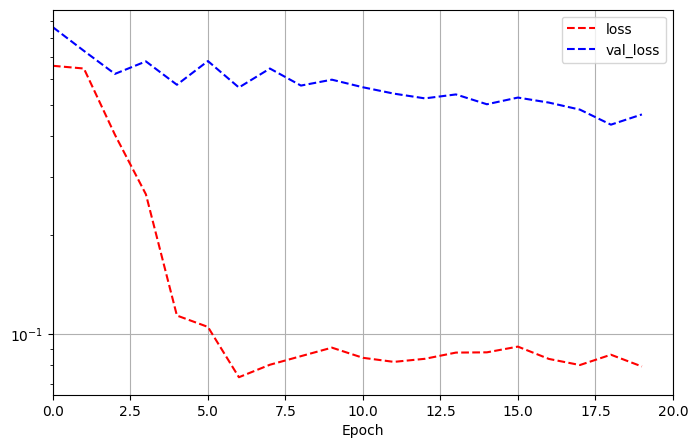

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(MLP_hist.history).plot(
figsize=(8, 5), xlim=[0, 20], logy=True, grid=True, xlabel="Epoch",
 style=["r--", "b--"])
plt.show()

This could be trained more due to the validation curve still decreasing, or even hyper parameters finetuned, but I don't plan on really using this MLP.

# CNN:
Seeing how well a CNN fares to implement in the VAE

In [22]:
filters=[5,10,20,30]
kernel_sizes=[3,3,3,3]
strides=[1,1,1,1]
def create_CNN_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(filters=filters[0],kernel_size=kernel_sizes[0],strides=strides[0],padding='same',input_shape=(None,mfeat,1)))
    model.add(tf.keras.layers.AvgPool1D(pool_size=2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    for i in range(len(filters)-1):
      model.add(tf.keras.layers.Conv1D(filters=filters[i+1],kernel_size=kernel_sizes[i+1],strides=strides[i+1],padding='same'))
      model.add(tf.keras.layers.AvgPool1D(pool_size=2))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

CNN_model = create_CNN_model()
CNN_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
def create_dataset(feat,labels,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((feat[:,:,None], labels))
    return dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(1)
train_set=create_dataset(train_features,train_labels['LOGG'])
valid_set=create_dataset(valid_features,valid_labels['LOGG'])
test_set=create_dataset(test_features,test_labels['LOGG'])

In [24]:
CNN_hist=CNN_model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - loss: 3.7133 - val_loss: 4.0902
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - loss: 0.2444 - val_loss: 3.7871
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - loss: 0.1390 - val_loss: 3.4236
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.1115 - val_loss: 2.9183
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 0.0918 - val_loss: 2.4769
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 0.0860 - val_loss: 2.1967
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - loss: 0.0697 - val_loss: 1.7523
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 0.0674 - val_loss: 1.2764
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - loss: 0.0656 - val_loss: 0.9867
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 0.0514 - val_loss: 0.5837
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - loss: 0.0453 - val_loss: 0.4306
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms

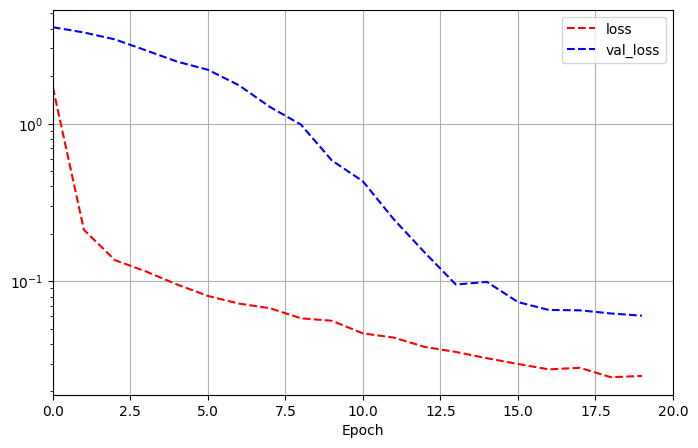

In [25]:
pd.DataFrame(CNN_hist.history).plot(
figsize=(8, 5), xlim=[0, 20], logy=True, grid=True, xlabel="Epoch",
 style=["r--", "b--"])
plt.show()

In [ ]:
results= model.evaluate(test_set)
print(results)
pred=model.predict(test_features[:10,:])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1800
0.1770588904619217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [ ]:
print(pred)
print(test_labels['LOGG'][:10])

[[0.3328795]
 [1.2301332]
 [2.5309465]
 [1.0576134]
 [2.349802 ]
 [2.6782405]
 [2.1213315]
 [0.8489586]
 [2.2309725]
 [1.0403563]]
[0.920775   1.074224   2.398953   0.8708589  2.4270613  2.4898858
 2.403348   0.85261536 2.808398   0.9820859 ]


# VAE
Let's make two VAEs trying either only feed-forward layers or only conv1d layers.

In [26]:
class Sampling(tf.keras.layers.Layer): #Custom Layer for sampling a Gaussian distribution from latent space
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

The VAEloss below is derived from optimizing the model parameters such that when we sample from the Normally distributed coding space, the decoder's output matches our encoder's input. See https://arxiv.org/pdf/1606.05908


In [27]:
class VAELoss(tf.keras.layers.Layer): #Dummy layer to add the new latent loss with the ordinary reconstruction loss
  def call(self, inputs):
    codings_mean, codings_log_var = inputs
    latent_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1))/mfeat
    self.add_loss(latent_loss)
    return inputs

In [31]:
def gen_vae_module(model,codings_size): #add the the generative layers for a given architecture
  codings_mean = tf.keras.layers.Dense(codings_size)(model) # μ
  codings_log_var = tf.keras.layers.Dense(codings_size)(model) # γ
  codings_mean, codings_log_var = VAELoss()([codings_mean, codings_log_var])
  codings = Sampling()([codings_mean, codings_log_var])
  return codings_mean, codings_log_var, codings

# Start out with an MLP VAE

In [32]:
codings_size=10
inputs = tf.keras.layers.Input(shape=[mfeat])
Z = tf.keras.layers.Dense(200, activation="relu")(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
codings_mean, codings_log_var, codings = gen_vae_module(Z,codings_size)
variational_encoder = tf.keras.Model(
 inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [33]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(150, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(200, activation="relu")(x)
outputs = tf.keras.layers.Dense(mfeat)(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [34]:
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=reconstructions)

In [35]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(train_features,train_features, epochs=25, batch_size=128,
 validation_data=(valid_features, valid_features))

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.6290 - val_loss: 0.1789
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.1016 - val_loss: 0.0478
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0568 - val_loss: 0.0405
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0324 - val_loss: 0.0221
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0212 - val_loss: 0.0195
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.0271 - val_loss: 0.0246
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0208 - val_loss: 0.0161
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 0.0160 - val_loss: 0.0146
Epoch 10/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0149 - val_loss: 0.0182
Epoch 11/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0216 - val_loss: 0.0160
Epoch 12/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0150 - val_lo

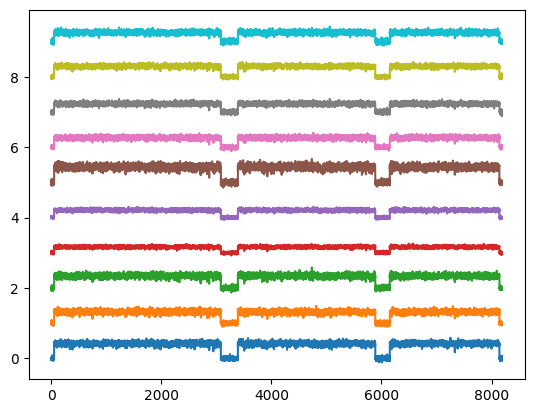

In [36]:
testcode=tf.random.normal(shape=[10,codings_size])
gen_spec=variational_decoder(testcode).numpy()
for i in range(10):
    plt.plot(gen_spec[i,:] + i)

In [37]:
variational_encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 8192)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 200)            │      1,638,600 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 150)            │         30,150 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 10)             │          1,510 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 10)             │          1,510 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss (VAELoss)        │ [(None, 10), (None,    │              0 │ dense_11[0][0],        │
│                           │ 10)]                   │                │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 10)             │              0 │ vae_loss[0][0],        │
│                           │                        │                │ vae_loss[0][1]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,671,770 (6.38 MB)

 Trainable params: 1,671,770 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

# Try out a CNN VAE

In [38]:
codings_size=10
filters=[5,10,20,40]
kernel_sizes=[3,3,3,3]
strides=[1,1,1,1]
inputs = tf.keras.layers.Input(shape=[mfeatev,1])
Z = tf.keras.layers.BatchNormalization()(inputs)
for i in range(len(filters)):
  Z = tf.keras.layers.Conv1D(filters=filters[i],kernel_size=kernel_sizes[i],strides=strides[i],padding='same')(Z)
  Z = tf.keras.layers.AvgPool1D(pool_size=2)(Z)
  Z = tf.keras.layers.BatchNormalization()(Z)
  Z = tf.keras.layers.ReLU()(Z)
Z = tf.keras.layers.Flatten()(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean, codings_log_var, codings = gen_vae_module(Z,codings_size)
variational_encoder = tf.keras.Model(
 inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [39]:
variational_encoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 8192, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 8192, 1)        │              4 │ input_layer_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 8192, 5)        │             20 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 4096, 5)        │              0 │ conv1d_4[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 4096, 5)        │             20 │ average_pooling1d_4[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 4096, 5)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 4096, 10)       │            160 │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_5       │ (None, 2048, 10)       │              0 │ conv1d_5[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 2048, 10)       │             40 │ average_pooling1d_5[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 2048, 10)       │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 2048, 20)       │            620 │ re_lu_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_6       │ (None, 1024, 20)       │              0 │ conv1d_6[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 1024, 20)       │             80 │ average_pooling1d_6[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 1024, 20)       │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 1024, 40)       │          2,440 │ re_lu_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_7  

 Total params: 2,053,664 (7.83 MB)

 Trainable params: 2,053,512 (7.83 MB)

 Non-trainable params: 152 (608.00 B)

In [41]:
filters=[40,20,10,1]
strides=[2,2,2,2]
kernel_sizes=[3,3,3,3]
dense_size=int(mfeat/2**len(filters))
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(dense_size, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape((dense_size,1))(x)
for i in range(len(filters)):
  x = tf.keras.layers.Conv1DTranspose(filters=filters[i],kernel_size=kernel_sizes[i],strides=strides[i],padding='same', activation="relu")(x)
outputs = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(200, activation="relu")(x)
#outputs = tf.keras.layers.Dense(mfeat)(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [42]:
variational_decoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 512, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 1024, 40)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 2048, 20)            │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 4096, 10)            │             610 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_3 (Conv1DTranspose) │ (None, 8192, 1)             │              31 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,853 (34.58 KB)

 Trainable params: 8,853 (34.58 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=reconstructions)

In [44]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(train_features,train_features, epochs=25, batch_size=128,
 validation_data=(valid_features, valid_features))

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 1765.9048 - val_loss: 0.9139
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 2.5262 - val_loss: 0.8937
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.6885 - val_loss: 0.8636
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 1.2296 - val_loss: 0.8268
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.9785 - val_loss: 0.7847
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.8514 - val_loss: 0.7382
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.7684 - val_loss: 0.6873
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.6959 - val_loss: 0.6312
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.6237 - val_loss: 0.5690
Epoch 10/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.5501 - val_loss: 0.4997
Epoch 11/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.4700 - val_loss: 0.4200
Epoch 12/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.3802 - val_loss: 0.3350
Epoch 13/25

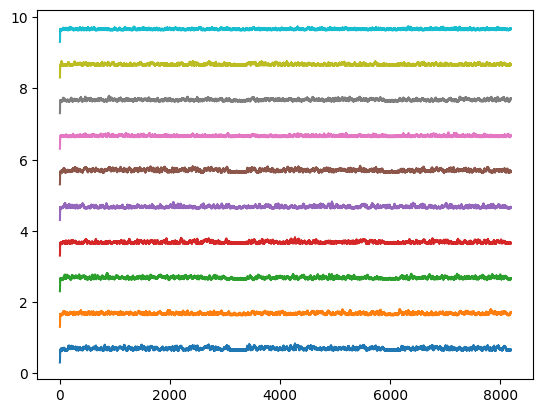

In [45]:
testcode=tf.random.normal(shape=[10,codings_size])
gen_spec=variational_decoder(testcode).numpy()
for i in range(10):
    plt.plot(gen_spec[i,:] + i)

In [46]:
model.predict(gen_spec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


array([[1903047.5],
       [1875173.8],
       [1864407.2],
       [1881602.8],
       [1886599.4],
       [1900230.8],
       [1921821. ],
       [1890687.6],
       [1943568.5],
       [1875616. ]], dtype=float32)

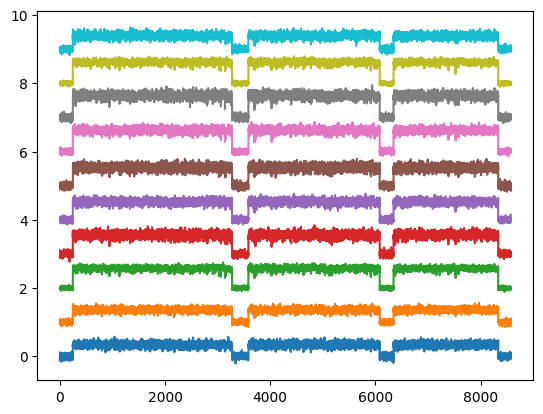

In [ ]:
testcode=tf.random.normal(shape=[10,codings_size])
gen_spec=variational_decoder(testcode).numpy()
for i in range(10):
    plt.plot(gen_spec[i,:] + i)

In [ ]:
model.predict(gen_spec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[  5635.307 ],
       [-10723.739 ],
       [ -4886.3315],
       [-51270.527 ],
       [ 16775.348 ],
       [-18735.861 ],
       [ 20798.771 ],
       [ 21724.803 ],
       [ 24850.08  ],
       [ 21900.115 ]], dtype=float32)

In [ ]:
test_labels['LOGG']

array([0.920775  , 1.074224  , 2.398953  , 0.8708589 , 2.4270613 ,
       2.4898858 , 2.403348  , 0.85261536, 2.808398  , 0.9820859 ,
       1.7071176 , 0.9888453 , 1.8631136 , 2.3819761 , 1.1506026 ,
       2.3937106 , 2.7396674 , 0.9985979 , 2.4660876 , 2.5334022 ,
       2.7651834 , 2.4789896 , 2.376651  , 2.6510518 , 2.4435108 ,
       0.8125447 , 0.9637552 , 2.565066  , 0.78283757, 2.8601446 ,
       1.6429863 , 2.3806643 , 0.7937472 , 0.7015706 , 1.2598863 ,
       2.0954225 , 1.9027402 , 2.7980857 , 2.9164412 , 2.4822764 ,
       0.42711002, 2.8716419 , 2.6164486 , 0.8161989 , 1.1576412 ,
       1.5726635 , 2.3743868 , 2.5045593 , 2.533553  , 2.576993  ,
       1.9328728 , 2.379281  , 1.5605392 , 2.5162978 , 2.0135586 ,
       1.4398739 , 2.4719586 , 1.8842878 , 1.3831518 , 2.6328893 ,
       2.6606858 , 2.400342  , 2.0852134 , 2.547438  , 2.5301025 ,
       1.9815438 , 0.96867734, 2.4709187 , 2.975101  , 2.2473483 ,
       2.5646586 , 2.2468753 , 2.4397943 , 2.457472  , 1.99680